# Notebook Imports

In [121]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

# Constants

In [122]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Generator function

In [123]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):  # walh() walks through all the files 
                                                # and returs root location, file name, directory name
        for file_name in filenames:
            
            # extracting messege body
            filepath = join(root, file_name)  # creating file path
            
            stream = open(filepath, encoding='latin-1')  # opening file

            is_body = False  # false, until reaches blank line \n
            lines = []  # stores lines after \n

            for line in stream:  # loops through all the lines
                if is_body:
                    lines.append(line)  # if is False until \n
                elif line == '\n':
                    is_body = True

            stream.close()  # closes file

            email_body = '\n'.join(lines)  # joins all the lines creates whole messege
            
            yield file_name, email_body  # doesnt return, only generates these two outputs


In [124]:
# to use the generator files outputs

def df_from_directory(path, classification):
    rows = []  # contains messege and category(spam or not)
    row_names = [] # contains names
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)  # puts them all into a dataframe

In [125]:
# using the function

spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails.append(df_from_directory(SPAM_2_PATH, 1)) # adds spam_2 as well
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [126]:
spam_emails.shape # both spam_1 and spam_2

(501, 2)

In [127]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [128]:
ham_emails.shape # both ham_1 and ham_2

(3901, 2)

#### Created Data
Concatnating ham and spam

In [129]:
# data = all emails ham & spam

data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)

Shape of entire dataframe is  (4402, 2)


In [130]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [131]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data cleaning: checking for missing values

In [132]:
# check if any message bodies are null
data['MESSAGE'].isnull()  # checks which messege are null(False if not null)
data['MESSAGE'].isnull().values  # takes the values into array (True or False)
data['MESSAGE'].isnull().values.any()  # checks if any of the value is null(True), returns False if all of them are not null

False

In [133]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any() # True if there are
(data.MESSAGE.str.len() == 0).sum() # Checks how many are True(1) and returns sum

2

In [134]:
#how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

# Locate empty e-mails

In [135]:
type(data.MESSAGE.str.len() == 0) #type is a pandas series

pandas.core.series.Series

In [136]:
data[data.MESSAGE.str.len() == 0].index # index's for data with no string ('cmds', 'cmds', 'cmds')

Index(['cmds', 'cmds'], dtype='object')

In [137]:
# How to locate by using index
data.index.get_loc('00004.eac8de8d759b7e74154f142194282724') 

3

# Remove system files entries from dataframe

In [138]:
data.drop(['cmds'], inplace=True) # inplace: replace current data
data.shape # shape is reduced as 3 'cmds' are dropped

(4400, 2)

# Add Document IDs to Track Emails in Dataset

In [139]:
document_ids = range(0, len(data.index)) # 1,2,3,4,5,6,7...

data['DOC_ID'] = document_ids # adds new column 'DOC_ID'

In [140]:
data['FILE_NAME'] = data.index # adds column 'FILE_NAME' to store all indexs
data.set_index('DOC_ID', inplace=True) # sets 'DOC_ID' as index 1,2,3,4,5,6,7...
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [141]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
4395,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
4396,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
4397,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
4398,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
4399,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save the file to disk using pandas

In [142]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages visualized (pie charts)


In [143]:
data.CATEGORY.value_counts() # counts how much values in each category

0    3900
1     500
Name: CATEGORY, dtype: int64

In [144]:
# put them into variables
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

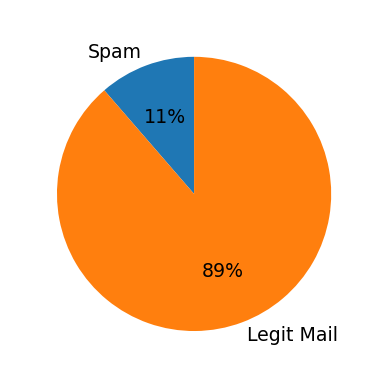

In [145]:
# creating pie chart

category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

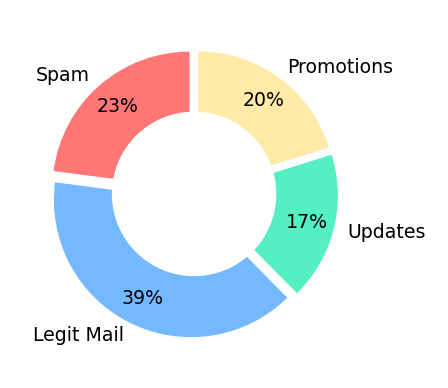

In [146]:
#creating donut chart 

category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle in the middle of pie to make donut
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing (NLP)

## Pre-processing the emails so the algorithm can understand

1. Converting to lowercase
2. Tokenising ( split up individual words in a sentence )
3. Removing the stop words ( removing common words like 'the', that are there for the grammer and doesn't convey any meaning )
4. Stripping out HTML
5. Word stemming ( Coverting individual words into their stem words e.g. 'goes', 'go', 'going' has the same word stem 'go' )
6. Remove punctuation ( As naive algorithm ignores grammer )

### Download the NLTK Resources (Tokenizer & Stopwords)
 

In [147]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [148]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [149]:
msg = 'This is a test message'
word_tokenize(msg.lower())  # lower() to transform to lowercase

['this', 'is', 'a', 'test', 'message']

In [150]:
stop_words = set(stopwords.words('english')) # transforming list to set
type(stop_words)

set

In [151]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### Word stems and stemming

In [152]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing punctuation

In [153]:
'?'.isalpha() # returns False if not a character

False

In [154]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from email

In [155]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify()) # to beautify the text

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [156]:
soup.get_text()  # get text

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

### Function for E-mail Processing

In [157]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))  # words to word stem
    
    return filtered_words

In [158]:
print(clean_message(data.at[2, 'MESSAGE']))

['fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl', 'commun', 'http', 'start', 'privat', 'photo', 'album', 'onlin', 'http', 'wonder', 'day', 'offer', 'manag', 'prizemama', 'wish', 'leav', 'list', 'pleas', 'use', 'link', 'http', 'zzzz']


In [159]:
#Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 

def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
           # filtered_words.append(word) 
    
    return filtered_words

In [160]:
print(clean_msg_no_html(data.at[2, 'MESSAGE']))

['fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl', 'commun', 'http', 'start', 'privat', 'photo', 'album', 'onlin', 'http', 'wonder', 'day', 'offer', 'manag', 'prizemama', 'wish', 'leav', 'list', 'pleas', 'use', 'link', 'http', 'zzzz']


### Apply cleaning and tokenisation to all messages

#### Slicing Dataframes and Series & Creating Subsets

In [161]:
data.iat[2, 0]  # 2 is row, 0 is column(message)

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [162]:
data.iloc[5:11]  # gets all entries from 5 to 10

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [163]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message) # apply(), to apply a function on data

In [164]:
# puts all items in one array

# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

321

In [165]:
print(flat_list)

['doctyp', 'html', 'public', 'html', 'html', 'head', 'meta', 'ype', 'meta', 'mshtml', 'bodi', 'insert', 'calypso', 'tabl', 'color', 'black', 'display', 'none', 'tbodi', 'tr', 'td', 'hr', 'noshad', 'tr', 'td', 'hr', 'noshad', 'end', 'calypso', 'insert', 'font', 'arial', 'helvetica', 'br', 'end', 'calypso', 'font', 'copperpl', 'gothic', 'bold', 'center', 'save', 'life', 'font', 'copperpl', 'gothic', 'bold', 'center', 'spend', 'center', 'font', 'copperpl', 'gothic', 'bold', 'center', 'life', 'quot', 'save', 'center', 'p', 'p', 'br', 'p', 'center', 'tabl', 'tbodi', 'tabl', 'tbodi', 'tr', 'td', 'b', 'font', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'tr', 'td', 'tabl', 'tbodi', 'tr', 'td', 'font', 'b', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand'

In [166]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\user\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 20.2 s


In [167]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
4395    [http, bizarr, collect, stuf, anim, could, fet...
4396    [care, use, one, also, realli, cute, thing, ja...
4397    [sm, skip, montanaro, write, jeremi, put, anot...
4398    [mark, hammond, like, given, zodb, sound, attr...
4399    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 4400, dtype: object

### Using logic to slice Dataframe

In [168]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [169]:
doc_ids_ham

Int64Index([ 500,  501,  502,  503,  504,  505,  506,  507,  508,  509,
            ...
            4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a series with an index

In [170]:
type(doc_ids_ham)  # Index

pandas.core.indexes.numeric.Int64Index

In [171]:
type(nested_list)  # Series

pandas.core.series.Series

In [172]:
nested_list_spam = nested_list.loc[doc_ids_spam]  # creates a nested list with all spams
nested_list_spam

DOC_ID
0      [save, life, insur, spend, life, quot, save, g...
1      [fight, risk, cancer, http, slim, guarante, lo...
2      [fight, risk, cancer, http, slim, guarante, lo...
3      [adult, club, offer, free, membership, instant...
4      [thought, might, like, slim, guarante, lose, l...
                             ...                        
495    [toy, abc, good, morn, america, rank, christma...
496    [untitl, document, let, mortgag, lender, compe...
497    [html, email, messag, see, mail, client, suppo...
498    [famou, ebay, market, learn, sell, complet, au...
499    [p, color, navi, hello, chines, tradit, äúïëò,...
Name: MESSAGE, Length: 500, dtype: object

In [173]:
nested_list_ham = nested_list.loc[doc_ids_ham]  # creates a nested list with all hams
nested_list_ham

DOC_ID
500     [date, wed, aug, chri, garrigu, ca, reproduc, ...
501     [martin, post, tasso, papadopoulo, greek, scul...
502     [man, threaten, explos, moscow, thursday, augu...
503     [klez, viru, wo, die, alreadi, prolif, viru, e...
504     [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
4395    [http, bizarr, collect, stuf, anim, could, fet...
4396    [care, use, one, also, realli, cute, thing, ja...
4397    [sm, skip, montanaro, write, jeremi, put, anot...
4398    [mark, hammond, like, given, zodb, sound, attr...
4399    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [174]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]  # all words in ham messages
normal_words = pd.Series(flat_list_ham).value_counts()  # value_count to get unique words put into series

normal_words.shape[0] # total number of unique words in the non-spam messages

20755

In [175]:
normal_words[:10] # first 10 unique words

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [176]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

7160

In [177]:
spammy_words[:10]

free      650
email     632
http      617
receiv    546
money     505
list      481
pleas     475
get       466
order     414
name      411
dtype: int64

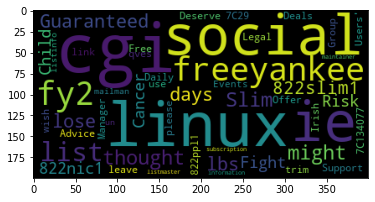

In [178]:
word_cloud = WordCloud().generate(data.iat[4, 0])
plt.imshow(word_cloud)

plt.show()

### Generate Vocabulary & Dictionary

In [179]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html) # generates messages with only words
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist] # contains all words in each message

In [180]:
unique_words = pd.Series(flat_stemmed_list).value_counts() # counts unique words and puts in series
print('Nr of unique words', unique_words.shape[0]) 
unique_words.head() # shows top ones

Nr of unique words 23279


http    8178
use     3918
list    3359
get     2750
one     2746
dtype: int64

In [181]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10]) # prints top 10

Most common words: 
 http      8178
use       3918
list      3359
get       2750
one       2746
mail      2647
would     2200
like      2114
messag    2104
time      2094
dtype: int64


In [182]:
print('Type of frequesnt word is: ', type(frequent_words))

Type of frequesnt word is:  <class 'pandas.core.series.Series'>


### Create Vocabulary Dataframe with WORD_ID

In [183]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,get
4,one


In [184]:
vocab.VOCAB_WORD # prints the whole VOCAB_WORD column


WORD_ID
0          http
1           use
2          list
3           get
4           one
         ...   
2495    richard
2496    idefens
2497     desert
2498    presenc
2499     zealot
Name: VOCAB_WORD, Length: 2500, dtype: object

### Save the Vocabulary as csv file

In [185]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

### Checking if a Word is Part of the Vocabulary

In [186]:
# 2,100 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'

In [187]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [188]:
'machine' in set(vocab.VOCAB_WORD) # better way

False

### Find the Email with the Most Number of Words

In [189]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [190]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [191]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 4379


In [192]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [193]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE'] #.at to return the row, and .iat to return location number

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

In [194]:
stemmed_nested_list[0:10]


DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
5    [powerhous, gift, program, want, miss, get, fo...
6    [help, want, year, old, fortun, compani, grow,...
7    [reliaquot, save, life, insur, life, chang, in...
8    [tire, bull, want, stop, lose, money, want, re...
9    [dear, cost, effect, direct, email, advertis, ...
Name: MESSAGE, dtype: object

### Generate Features & a Sparse Matrix

#### Creating a DataFrame with one Word per Column

In [195]:
type(stemmed_nested_list)

pandas.core.series.Series

In [196]:
type(stemmed_nested_list.tolist()) # changing type to list makes it easier to create pd.dataframe

list

In [197]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())  # creating dataframe
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [198]:
word_columns_df.shape 

(4400, 7671)

### Splitting the Data into a Training and Testing Dataset

In [199]:
# Note: X_train is a pandas dataframe, and y_train is a pandas series

X_train, X_test, y_train, y_test = train_test_split(word_columns_df, # X values are all the words in each word_id
                                                    data.CATEGORY,  # y values are the spam_ham category
                                                    test_size=0.3, #70% split and shuffle
                                                    random_state=42)

In [200]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 3080
Fraction of training set 0.7


In [201]:
X_train.index.name = X_test.index.name = 'DOC_ID' # giving index a name 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1829,updat,directori,modifi,file,log,messag,remov,index,rc,file,...,None,None,None,None,None,None,None,None,None,None
2274,use,perl,daili,headlin,mailer,week,august,septemb,post,rafael,...,None,None,None,None,None,None,None,None,None,None
218,introduct,sell,backup,cd,also,known,warez,cd,backup,cd,...,None,None,None,None,None,None,None,None,None,None
3793,date,tue,aug,ever,tri,get,mh,sequenc,hmm,use,...,None,None,None,None,None,None,None,None,None,None
1770,upon,time,vill,wrote,btw,think,kake,ogl,packag,automat,...,None,None,None,None,None,None,None,None,None,None


In [202]:
y_train.head()


DOC_ID
1829    0
2274    0
218     1
3793    0
1770    0
Name: CATEGORY, dtype: int64

In [203]:
vocab.VOCAB_WORD.values[4]

'one'

### Create a Sparse Matrix for the Training Data

In [204]:
word_index = pd.Index(vocab.VOCAB_WORD) # an index file that has all the vocab words as index(str)
type(word_index[3])

str

In [205]:
word_index.get_loc('thu') # get location of each word(index)

267

In [206]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test) - X_train
    indexed_words: index of words ordered by word id - vocab
    labels: category as a series (y_train or y_test) - y_train
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [207]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 1min 48s


In [208]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
302744,0,860,1,93
302745,0,860,1,680
302746,0,860,1,580
302747,0,860,1,50
302748,0,860,1,1162


In [209]:
sparse_train_df.shape

(302749, 4)

#### Combine Occurrences with the Pandas groupby() Method

In [210]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()  # sums the occurances by group
train_grouped[0:11]

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              1
       11      1              2
       13      1              1
       14      1              1
       29      1              3
       41      1              1
       48      1              1
       49      1              1
       51      1              1
       53      1              1

In [211]:
vocab.at[29, 'VOCAB_WORD'] # the first word at index 0, and column VOCAB_WORD

'free'

In [212]:
data.MESSAGE[0] # the first message, the word 'free' occurs three times

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [213]:
train_grouped = train_grouped.reset_index() # to make DOC_ID appear in every single row
train_grouped

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,1
2,0,11,1,2
3,0,13,1,1
4,0,14,1,1
...,...,...,...,...
189495,4397,1952,0,3
189496,4397,2047,0,1
189497,4397,2074,0,1
189498,4397,2076,0,1


In [214]:
train_grouped.shape # shape is reduced


(189500, 4)

### Save Training Data as .txt File

In [215]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [216]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### Create a Sparse Matrix for the Testing Data
And then saving it as txt file

In [217]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 45.6 s


In [218]:
sparse_test_df.shape

(129739, 4)

In [219]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index() # summing occurence
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,6,0,1,2
1,6,4,1,1
2,6,10,1,1
3,6,12,1,1
4,6,14,1,1


In [220]:
test_grouped.shape # size reduced

(81338, 4)

In [221]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d') # saving file as txt

### Pre-Processing Subtleties and Checking your Understanding
Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing.

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [222]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [223]:
len(test_doc_ids)

1310

In [224]:
len(X_test)

1320

In [225]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{73, 134, 179, 205, 240, 274, 298, 402, 439, 471}

In [226]:
data.MESSAGE[471] # because these have jibrish text

'------=_NextPart_000_00E3_67D27D5C.B1748B87\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nR2V0IGFjY2VzcyB0byB0aGUgbGFyZ2VzdCBmcmVlIGFkdWx0IHNpdGUgb24g\n\ndGhlIG5ldC4NCg0KaHR0cDovL3d3dy5teWZyZWVhZHVsdHBheXNpdGUuY29t\n\nL2ZyZWVzaXRlLmh0bWwNCjM4NjJ5VVJQOC03OTdoam9qNzY2MHhubFk5LTY1\n\nMVBGWFIyOTYzS2tBaDYtMzgya0tLUDQxN2w1MQ==\n\n\n\n\n'

In [227]:
data.loc[471]

MESSAGE      ------=_NextPart_000_00E3_67D27D5C.B1748B87\n\...
CATEGORY                                                     1
FILE_NAME               00472.713268dfca421e165c1ac59bab045e00
Name: 471, dtype: object

In [228]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['lowest',
 'rate',
 'servic',
 'conferenc',
 'easi',
 'cent',
 'per',
 'minut',
 'includ',
 'long',
 'distanc',
 'setup',
 'fee',
 'contract',
 'monthli',
 'fee',
 'call',
 'anytim',
 'anywher',
 'anywher',
 'connect',
 'particip',
 'simplic',
 'set',
 'administr',
 'oper',
 'help',
 'avail',
 'highest',
 'qualiti',
 'servic',
 'lowest',
 'rate',
 'industri',
 'fill',
 'form',
 'low',
 'find',
 'lower',
 'phone',
 'bill',
 'everi',
 'requir',
 'input',
 'web',
 'address',
 'compani',
 'busi',
 'home',
 'phone',
 'email',
 'type',
 'busi',
 'remov',
 'distribut',
 'list',
 'pleas',
 'click']